In [1]:
import os
import csv
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import cv2
import numpy as np
import sklearn

In [3]:
from keras.models import Sequential
from keras.layers import Cropping2D,Lambda, ELU
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D

Using TensorFlow backend.
D:\anaconda\miniconda\envs\carnd-term1\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
samples = []
with open('./data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    next(reader,None) # skip header
    for line in reader:
        samples.append(line)


print('number of samples :', len(samples))
from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

number of samples : 8036


In [5]:
import math

def plot_multiple_images(images,names,gray=False,number_of_cols=6,w_factor=4,h_factor=2):
    
    number_of_images=len(images)

    number_of_rows=math.ceil(number_of_images*1.0/number_of_cols)

    
    
    fig_width=w_factor*number_of_cols  
    fig_height=h_factor*number_of_rows
    
    if number_of_rows > 5 :
        _dpi = number_of_rows * 5
    else :
        _dpi = 30
    
    #fig=plt.figure(figsize=(fig_width, fig_height),dpi=_dpi, facecolor='w', edgecolor='w')
    fig=plt.figure(figsize=(fig_width, fig_height), facecolor='w', edgecolor='w')
    
    im_number=0
    for im, name in zip(images,names):
        im_number+=1
        plt.subplot(number_of_rows,number_of_cols,im_number)
        plt.title(name)
        if gray :
            plt.imshow(im,cmap='gray')
        else :
            plt.imshow(im)

8036


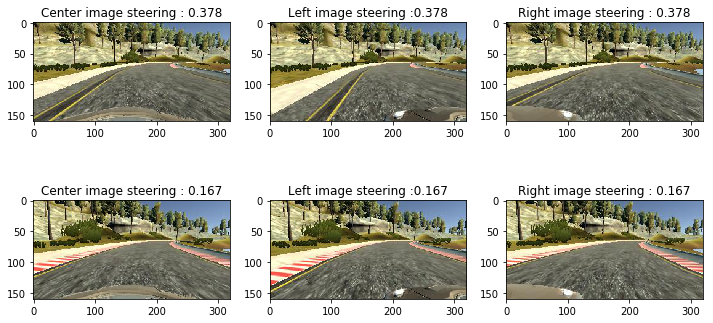

In [6]:
print(len(samples))
count=0
original_ims=[]
original_steerings=[]
ims_normalized=[]
ims=[]
steerings=[]



def get_label(index,steering,flipped=False,modifysteering=True):
        
        #print('>',steering,'<')
        steering=float(steering)
        if modifysteering :
        
            if index == 1 :
                steering = steering + 0.2
            elif index == 2 : 
                steering = steering - 0.2  

            if flipped :
                steering = -1.0 * steering
            
        if index == 0 :
            steering_str = 'Center image steering : ' + str(round(steering,3))
        elif index == 1 :
            steering_str = 'Left image steering :' + str(round(steering,3))
        elif index == 2 :
            steering_str = 'Right image steering : ' + str(round(steering,3))
        
        if flipped :
            
            steering_str= 'Flipped ' + steering_str
            
        return steering_str

#samples=sklearn.utils.shuffle(samples)
selected_sample=[]
#selected_sample.append(samples[3754])
selected_sample.append(samples[3644])
selected_sample.append(samples[269])
#selected_sample.append(samples[155])


for sample in selected_sample:
    count+=1
    if count > 4 :
        break;
    y=65
    h=160-y-20
    path = './data/IMG/' 
    for i in range(3):
        #print(sample[i])
        img = cv2.imread(path + sample[i].split('/')[-1])
        steering=sample[3]
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        im_cropped =img[y:y+h, :]
        original_ims.append(img)
        normalized = img - 127.5
        ims_normalized.append(normalized)
        #ims.append(img)
        ims.append(im_cropped)               
        steeing = get_label(i,steering,False)
        original_str = get_label(i,steering,False,False)
        original_steerings.append(original_str)
        steerings.append(steeing)
        #steerings.append(steeing)
        
        im_f=cv2.flip(im_cropped,1)
        #im_f=cv2.cvtColor(im_f,cv2.COLOR_BGR2RGB)
        steeing = get_label(i,steering,True)  
        ims.append(im_f)
        steerings.append(steeing)

plot_multiple_images(original_ims,original_steerings,gray=False,number_of_cols=3,h_factor=3)
#plot_multiple_images(ims,steerings,gray=False,number_of_cols=3)
    

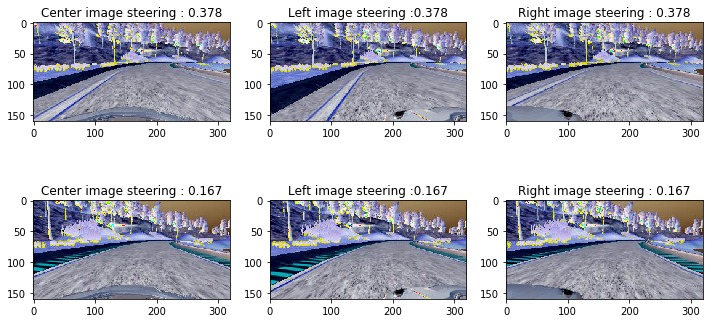

In [7]:
plot_multiple_images(ims_normalized,original_steerings,gray=False,number_of_cols=3,h_factor=3)

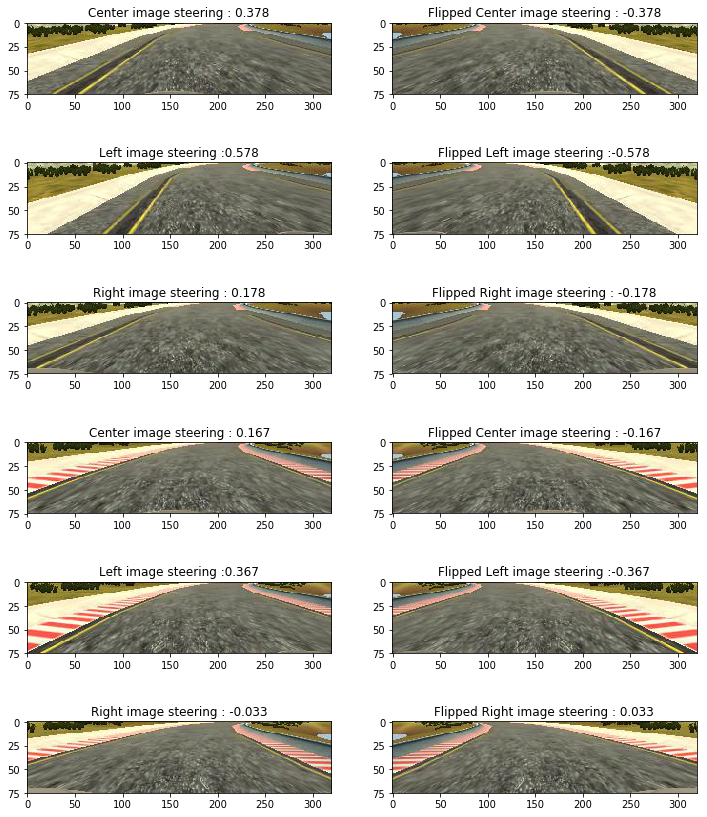

In [8]:
plot_multiple_images(ims,steerings,gray=False,number_of_cols=2,w_factor=6,h_factor=2.5)

In [9]:
import imageio
import os

In [10]:
dir_path='./run_for_demo'
filenames=[x for x in os.listdir(dir_path)]


In [11]:
images = []
for filename in filenames:
    filepath=dir_path+"/"+filename
    images.append(imageio.imread(filepath))
imageio.mimsave('./demo.gif', images)

In [12]:
def get_nvidia_model():
    model = Sequential()
    # Preprocess incoming data, centered around zero with small standard deviation 
    # crop images 50 pixels from top and 20 pixels from bottom
    # normalization
    model.add(Lambda(lambda x: x/255 - 0.5,input_shape=(160,320,3)))
    model.add(Cropping2D(cropping=((65,20), (0,0)))) #  output = 3@90x320
    model.add(Convolution2D(24, 5, 5, subsample=(2, 2),name='convo1')) # border_mode==padding # subsample == strides = out 16@43x158
    model.add(Activation('elu')) # exponetial linera units 
    model.add(Convolution2D(36, 5, 5, subsample=(2, 2),name='convo2')) # output 32@20x77
    model.add(Activation('elu'))
    model.add(Convolution2D(48, 5, 5, subsample=(2, 2),name='convo3')) # output 48@8x37
    model.add(Activation('elu'))
    model.add(Convolution2D(64, 3, 3, name='convo4')) # output 64@3x18
    model.add(Activation('elu'))
    model.add(Convolution2D(64, 3, 3, name='convo5')) # output 64@1x16
    model.add(Activation('elu'))
    model.add(Flatten())
    model.add(Dropout(0.50))
    model.add(Dense(100))
    model.add(Activation('elu'))
    model.add(Dropout(0.50))
    model.add(Dense(50))
    model.add(Activation('elu'))
    model.add(Dropout(0.20))
    model.add(Dense(10))
    model.add(Activation('elu'))
    #model.add(Dropout(0.50))
    model.add(Dense(1))
    
    return model

In [13]:
print('Building model')

model_file='model_here_11_.h5'
model=get_nvidia_model()


print('Complining model')
model.compile(loss='mse', optimizer='adam',metrics=['accuracy'])

print(model.summary())


Building model
Complining model
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 160, 320, 3)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
cropping2d_1 (Cropping2D)        (None, 75, 320, 3)    0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convo1 (Convolution2D)           (None, 36, 158, 24)   1824        cropping2d_1[0][0]               
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 36, 158, 24)   0           convo1[0][0]                     
___________________________________________________________

In [15]:
import pickle

In [16]:
history=None
file_name='model.pkl'
with open(file_name, 'rb') as pickle_file:
    history=pickle.load(pickle_file)

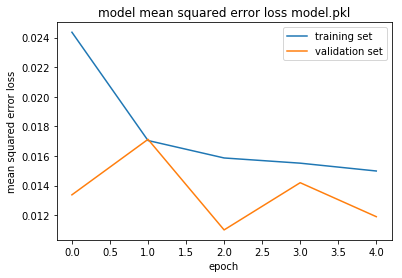

In [17]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model mean squared error loss '+file_name)
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

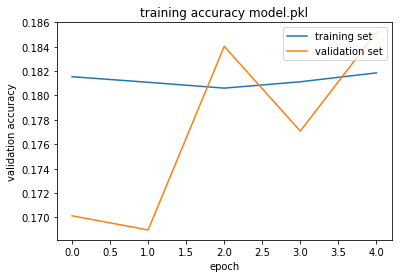

In [18]:
plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.title('training accuracy '+file_name)
plt.ylabel('validation accuracy')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()